In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from sklearn.datasets import load_digits
from numpy.random import choice
from sklearn.metrics import pairwise_distances_argmin
from sklearn.metrics import pairwise_distances
import random
from sklearn.metrics import adjusted_rand_score, silhouette_samples, roc_auc_score
from scipy.stats import entropy

## Базовая реализация k-means

In [2]:
def kmeans_find_clusters(X, n_clusters, iter_num=50):
    # 1. Randomly choose clusters

    ind = np.random.permutation(X.shape[0])[:n_clusters]
    centers = X[ind]
    
    for _ in range(iter_num):
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0) for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

In [3]:
digits = load_digits()
digits.data.shape

(1797, 64)

In [4]:
centers, labels = kmeans_find_clusters(digits.data, n_clusters=10, iter_num=50)
centers.shape

(10, 64)

In [5]:
digits.data

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

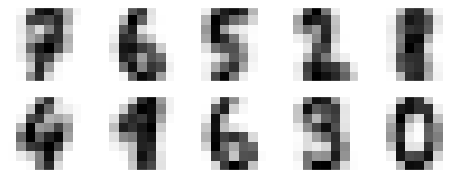

In [6]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers_img = centers.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers_img):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [30]:
set(digits.target)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

## Точность кластеризации с помощью accuracy

In [7]:
from scipy.stats import mode

labels_dig = np.zeros_like(labels)
for i in range(10):
    mask = (labels == i)
    labels_dig[mask] = mode(digits.target[mask])[0]
    
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels_dig)

0.7234279354479688

##  Adjusted Rand index

In [8]:
adjusted_rand_score(digits.target, labels_dig)

0.5952765706532109

## Silhouette Coefficient

In [9]:
np.mean(silhouette_samples(digits.data, labels))

0.17261070108278273

## K++ means

In [10]:
def k_plusplus_means_find_clusters(X, n_clusters, iter_num=50, label_class = None):
    # 1. Randomly choose 1 center
    ind = random.randint(0, len(X) - 1)
    centers = [X[ind]]
    distance = np.array(cdist(X, centers)).T #distances between centers and points
    min_distance_1 = distance[0] #distances to the closest centers
    
    for i in range(1, n_clusters):
        distance = np.array(cdist(X, centers)).T
        min_distance = distance[0]
        for j in range(len(distance)):
            for k in range(len(min_distance)):
                min_distance[k] = min(min_distance[k], distance[j][k])
        min_distance = np.array(min_distance)**2
        indexes = np.arange(0, len(X))
        tmp = choice(indexes, p=min_distance/np.sum(min_distance)) #choose with prob=distance^2
        centers.append(X[tmp]) # add new center


    
    for _ in range(iter_num, label_class):
        lst_dist = pairwise_distances(X, centers)
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0) for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

In [14]:
X = digits.data
n_clusters=10
iter_num=50

In [15]:
lst_dist_label = []
for i in range(len(X)):
    lst_dist_label.append(np.argmin(pairwise_distances(X, centers)[i]))

In [16]:
pairwise_distances(X, centers)[0]

array([42.89960079, 45.39518458, 39.25236011, 46.01118142, 44.59793683,
       40.72610429, 44.67525821, 39.73651957, 34.18523421, 13.95812487])

In [17]:
set(lst_dist_label)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [18]:
pairwise_distances_argmin

<function sklearn.metrics.pairwise.pairwise_distances_argmin(X, Y, *, axis=1, metric='euclidean', metric_kwargs=None)>

In [19]:
# 1. Randomly choose 1 center
ind = random.randint(0, len(X) - 1)
centers = [X[ind]]
distance = np.array(cdist(X, centers)).T #distances between centers and points
min_distance_1 = distance[0] #distances to the closest centers
distance[0]

array([57.33236433, 46.62617291, 54.72659317, ..., 50.3487835 ,
       51.52669211, 47.84349486])

In [20]:
# 1. Randomly choose 1 center
ind = random.randint(0, len(X) - 1)
centers = [X[ind]]
distance = np.array(cdist(X, centers)).T #distances between centers and points
min_distance_1 = distance[0] #distances to the closest centers

for i in range(1, n_clusters):
    distance = np.array(cdist(X, centers)).T
    min_distance = distance[0]
    for j in range(len(distance)):
        for k in range(len(min_distance)):
            min_distance[k] = min(min_distance[k], distance[j][k])
    min_distance = np.array(min_distance)**2
    indexes = np.arange(0, len(X))
    tmp = choice(indexes, p=min_distance/np.sum(min_distance)) #choose with prob=distance^2
    centers.append(X[tmp]) # add new center

In [21]:
choice(indexes, p=min_distance/np.sum(min_distance))

1119

In [38]:
pd.Series(pairwise_distances_argmin(X, centers)).value_counts()

5    409
0    235
2    203
7    181
9    180
1    166
6    154
3    148
8     89
4     32
dtype: int64

In [48]:
labels = pairwise_distances_argmin(X, centers)

# 2b. Find new centers from means of points
new_centers = np.array([X[labels == i].mean(0) for i in range(n_clusters)])

centers = new_centers
old_labels = labels
old_labels

array([9, 0, 0, ..., 0, 5, 5])

In [54]:
X[old_labels == target_label]

array([[ 0.,  0., 12., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  5.,  0.],
       [ 0.,  0.,  6., ...,  3.,  0.,  0.],
       ...,
       [ 0.,  0.,  9., ..., 11.,  1.,  0.],
       [ 0.,  0.,  1., ...,  4.,  0.,  0.],
       [ 0.,  0., 10., ...,  4.,  0.,  0.]])

In [61]:
entropy([0, 0, 1, 0, 1])

0.6931471805599453

In [62]:
entropy([2, 2, 1, 2, 1])

1.559581156259877

In [65]:
entropy([True, True, False, True, False])

1.0986122886681096

In [66]:
entropy([False, False, True, False, True])

0.6931471805599453

In [75]:
list(target_labels[old_labels == 0] == 0) + [True]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,


In [79]:
np.array(pd.DataFrame([[0, 6], [5, 8]]))

array([[0, 6],
       [5, 8]])

In [142]:
entropy_true_res, entropy_false_res = \
            add_dist(n_clusters, old_labels, target_labels)
((target_labels == 0)*entropy_true_res[0]\
    + (target_labels != 0)*entropy_false_res[0])

array([0., 0., 0., ..., 0., 0., 0.])

In [143]:
entropy_false_res

[0, 0, 1.0986122886681096, 0, 0, 3.663561646129646, 0, 0, 1.791759469228055, 0]

In [102]:
entropy(list(target_labels[old_labels == 0] == 0) + [True])

0.0

In [133]:
cnst = entropy([False, False])
str(entropy([False, False]))

'nan'

In [129]:
entropy([0, 0])
ПОЧИНИТЬ!!!!!!!!!!!!!!!!!!

nan

In [145]:
entropy_true_res, entropy_false_res = \
            add_dist(n_clusters, old_labels, target_labels)
tmp_df = pd.DataFrame([], columns=range(n_clusters) )
for it in range(n_clusters):
    tmp_df[it] = ((target_labels == it)*entropy_true_res[it]\
    + (target_labels != it)*entropy_false_res[it])

In [151]:
(target_labels == it)*entropy_true_res[it]

array([0., 0., 0., ..., 0., 0., 0.])

In [155]:
entropy_true_res

[0.0,
 0.0,
 1.3862943611198906,
 0.0,
 0.0,
 3.6888794541139367,
 0.0,
 0.0,
 1.9459101490553132,
 0.0]

In [154]:
entropy_false_res

[0, 0, 1.0986122886681096, 0, 0, 3.663561646129646, 0, 0, 1.791759469228055, 0]

In [149]:
tmp_df.describe()

,0,1,2,3,4,5,6,7,8,9
count,1797.0,1797.0,1797.000000,1797.0,1797.0,1797.000000,1797.0,1797.0,1797.000000,1797.0
mean,0.0,0.0,1.126948,0.0,0.0,3.666126,0.0,0.0,1.806686,0.0
std,0.0,0.0,0.085749,0.0,0.0,0.007640,0.0,0.0,0.045599,0.0
min,0.0,0.0,1.098612,0.0,0.0,3.663562,0.0,0.0,1.791759,0.0
25%,0.0,0.0,1.098612,0.0,0.0,3.663562,0.0,0.0,1.791759,0.0
50%,0.0,0.0,1.098612,0.0,0.0,3.663562,0.0,0.0,1.791759,0.0
75%,0.0,0.0,1.098612,0.0,0.0,3.663562,0.0,0.0,1.791759,0.0
max,0.0,0.0,1.386294,0.0,0.0,3.688879,0.0,0.0,1.945910,0.0


In [137]:
lst_tmp = []
for i in range(100):
    lst_tmp.append(False)
lst_tmp.append(True)
entropy(lst_tmp)

0.0

In [141]:
def add_dist(n_clusters, clust_labels, target_labels):
    true_list = []
    false_list = []
    entropy_true_res = []
    entropy_false_res = []
    for it in range(n_clusters):
        true_list = list(
            target_labels[clust_labels == it] == it
        ) + [True]
        false_list = list(
            target_labels[clust_labels == it] == it
        ) + [False]
        entropy_true_res.append(entropy(true_list))
        entropy_false = entropy(false_list)
        if str(entropy_false) == "nan":
            entropy_false_res.append(0)
        else:
            entropy_false_res.append(entropy_false)
    return entropy_true_res, entropy_false_res

In [165]:
np.argmin(np.array(pd.DataFrame(pairwise_distances(X, centers))\
            + tmp_df), axis = 1)

array([9, 0, 0, ..., 0, 5, 7])

In [186]:
pairwise_distances_argmin(X, centers)

array([9, 0, 0, ..., 0, 5, 5])

In [183]:

target_labels = digits.target
alpha = 1
def get_centeres(iter_num, alpha, target_labels):
    centers = [X[ind]]
    for _ in range(iter_num):

        if _ == 0:
            # 2a. Assign labels based on closest center
            labels = pairwise_distances_argmin(X, centers)

            # 2b. Find new centers from means of points
            new_centers = np.array([X[labels == i].mean(0) for i in range(n_clusters)])

            # 2c. Check for convergence
            if np.all(centers == new_centers):
                break
            centers = new_centers
            old_labels = labels
        else:

            # 2a. Assign labels based on closest center
            entropy_true_res, entropy_false_res = \
                add_dist(n_clusters, old_labels, target_labels)
            entropy_df = pd.DataFrame([], columns=range(n_clusters))
            for it in range(n_clusters):
                entropy_df[it] = ((target_labels == it)*entropy_true_res[it]\
                + (target_labels != it)*entropy_false_res[it])
            dist_to_centers = pd.DataFrame(pairwise_distances(X, centers))\
                + alpha * entropy_df

    #         labels = pairwise_distances_argmin(X, centers)
            labels = np.argmin(np.array(dist_to_centers), axis = 1)

            # 2b. Find new centers from means of points
            new_centers = np.array([X[labels == i].mean(0) for i in range(n_clusters)])

            # 2c. Check for convergence
            if np.all(centers == new_centers):
                break
            centers = new_centers
            old_labels = labels
    return centers

In [218]:
# 1. Randomly choose 1 center
ind = random.randint(0, len(X) - 1)

In [226]:
ind

689

In [231]:
centers = [X[ind]]
distance = np.array(cdist(X, centers)).T #distances between centers and points
min_distance_1 = distance[0] #distances to the closest centers

for i in range(1, n_clusters):
    distance = np.array(cdist(X, centers)).T
    min_distance = distance[0]
    for j in range(len(distance)):
        for k in range(len(min_distance)):
            min_distance[k] = min(min_distance[k], distance[j][k])
    min_distance = np.array(min_distance)**2
    indexes = np.arange(0, len(X))
    tmp = choice(indexes, p=min_distance/np.sum(min_distance)) #choose with prob=distance^2
    centers.append(X[tmp]) # add new center

In [236]:
np.argmin(pairwise_distances(X, centers), axis = 1)

array([8, 5, 2, ..., 5, 9, 3])

In [235]:
pairwise_distances_argmin(X, centers)

array([8, 5, 2, ..., 5, 9, 3])

In [229]:
centers

alpha = 10
for _ in range(iter_num):

    if _ == 0:
        
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)

        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0) for i in range(n_clusters)])

        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
        old_labels = labels
    else:

        # 2a. Assign labels based on closest center
        entropy_true_res, entropy_false_res = \
            add_dist(n_clusters, old_labels, target_labels)
        entropy_df = pd.DataFrame([], columns=range(n_clusters))
        for it in range(n_clusters):
            entropy_df[it] = ((target_labels == it)*entropy_true_res[it]\
            + (target_labels != it)*entropy_false_res[it])
        dist_to_centers = pd.DataFrame(pairwise_distances(X, centers))\
            + alpha * entropy_df

#         labels = pairwise_distances_argmin(X, centers)
        labels = np.argmin(np.array(dist_to_centers), axis = 1)

        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0) for i in range(n_clusters)])

        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
        old_labels = labels
print(_)

/home/mahir/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2686: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
<ipython-input-229-4735efcb9d9f>:50: RuntimeWarning: Mean of empty slice.
  new_centers = np.array([X[labels == i].mean(0) for i in range(n_clusters)])
/home/mahir/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/mahir/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2686: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [222]:
centers[:1]

array([[0.00000000e+00, 1.90476190e-01, 5.05238095e+00, 1.30047619e+01,
        1.39666667e+01, 1.07952381e+01, 4.84761905e+00, 9.14285714e-01,
        0.00000000e+00, 1.13333333e+00, 1.07238095e+01, 1.14476190e+01,
        1.03095238e+01, 1.25190476e+01, 5.43809524e+00, 5.23809524e-01,
        0.00000000e+00, 1.17142857e+00, 5.56190476e+00, 2.40952381e+00,
        6.92857143e+00, 1.16095238e+01, 3.37142857e+00, 1.09523810e-01,
        0.00000000e+00, 9.66666667e-01, 5.07142857e+00, 6.63333333e+00,
        1.23095238e+01, 1.19238095e+01, 4.61428571e+00, 4.76190476e-03,
        0.00000000e+00, 1.42857143e+00, 8.38095238e+00, 1.27952381e+01,
        1.46761905e+01, 1.05095238e+01, 3.84285714e+00, 0.00000000e+00,
        0.00000000e+00, 1.09523810e+00, 5.00476190e+00, 1.13095238e+01,
        1.11380952e+01, 3.65714286e+00, 5.38095238e-01, 0.00000000e+00,
        0.00000000e+00, 1.00000000e-01, 2.90952381e+00, 1.23571429e+01,
        6.41904762e+00, 4.14285714e-01, 9.52380952e-03, 0.000000

In [228]:
centers[:1]

array([[0.00000000e+00, 3.01094891e-01, 6.17700730e+00, 1.16788321e+01,
        1.27956204e+01, 7.80474453e+00, 1.28832117e+00, 3.64963504e-02,
        5.47445255e-03, 2.57846715e+00, 1.18613139e+01, 9.58941606e+00,
        1.03521898e+01, 1.15000000e+01, 2.26824818e+00, 3.46715328e-02,
        1.82481752e-03, 2.97262774e+00, 9.21167883e+00, 5.42700730e+00,
        8.82116788e+00, 1.07463504e+01, 1.85218978e+00, 1.27737226e-02,
        0.00000000e+00, 1.86861314e+00, 7.61313869e+00, 1.06496350e+01,
        1.32974453e+01, 1.00018248e+01, 1.55656934e+00, 0.00000000e+00,
        0.00000000e+00, 5.14598540e-01, 3.44343066e+00, 6.27554745e+00,
        9.63321168e+00, 1.13613139e+01, 2.82481752e+00, 0.00000000e+00,
        0.00000000e+00, 4.54379562e-01, 2.48540146e+00, 2.00000000e+00,
        4.57481752e+00, 1.17189781e+01, 4.87043796e+00, 1.82481752e-03,
        0.00000000e+00, 7.44525547e-01, 6.72445255e+00, 5.75547445e+00,
        7.69343066e+00, 1.26514599e+01, 4.72445255e+00, 8.029197

In [220]:
_

20

In [194]:
centers = [X[ind]]
# 2a. Assign labels based on closest center
labels = pairwise_distances_argmin(X, centers)

# 2b. Find new centers from means of points
new_centers = np.array([X[labels == i].mean(0) for i in range(n_clusters)])

<ipython-input-194-647f15333518>:6: RuntimeWarning: Mean of empty slice.
  new_centers = np.array([X[labels == i].mean(0) for i in range(n_clusters)])
/home/mahir/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


In [197]:
np.array([X[labels == i].mean(0) for i in range(n_clusters)])

AttributeError: 'list' object has no attribute 'mean'

In [201]:
pd.Series(pairwise_distances_argmin(X, centers)).unique()

array([0])

In [184]:
alpha = 10
res1 = get_centeres(iter_num, alpha, target_labels)
res1[:1]

<ipython-input-183-b77afce35e29>:12: RuntimeWarning: Mean of empty slice.
  new_centers = np.array([X[labels == i].mean(0) for i in range(n_clusters)])
/home/mahir/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/mahir/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2686: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [193]:
new_centers

array([[0.00000000e+00, 3.03839733e-01, 5.20478575e+00, 1.18358375e+01,
        1.18480801e+01, 5.78185865e+00, 1.36227045e+00, 1.29660545e-01,
        5.56483027e-03, 1.99387869e+00, 1.03823038e+01, 1.19794101e+01,
        1.02793545e+01, 8.17584864e+00, 1.84641068e+00, 1.07957707e-01,
        2.78241514e-03, 2.60155815e+00, 9.90317195e+00, 6.99276572e+00,
        7.09794101e+00, 7.80634391e+00, 1.78853645e+00, 5.00834725e-02,
        1.11296605e-03, 2.46967168e+00, 9.09126322e+00, 8.82136895e+00,
        9.92710072e+00, 7.55147468e+00, 2.31775181e+00, 2.22593211e-03,
        0.00000000e+00, 2.33945465e+00, 7.66722315e+00, 9.07178631e+00,
        1.03016138e+01, 8.74401781e+00, 2.90929327e+00, 0.00000000e+00,
        8.90372844e-03, 1.58375070e+00, 6.88146912e+00, 7.22815804e+00,
        7.67223150e+00, 8.23650529e+00, 3.45631608e+00, 2.72676683e-02,
        7.23427935e-03, 7.04507513e-01, 7.50695604e+00, 9.53923205e+00,
        9.41624930e+00, 8.75848637e+00, 3.72509738e+00, 2.064552

In [44]:
pd.Series(target_label).value_counts()

3    183
5    182
1    182
6    181
4    181
9    180
7    179
0    178
2    177
8    174
dtype: int64

## Датасет MNIST

In [10]:
digits = load_digits()
digits.data.shape

(1797, 64)

In [11]:
centers, labels = k_plusplus_means_find_clusters(digits.data, n_clusters=10, iter_num=50)
centers.shape

(10, 64)

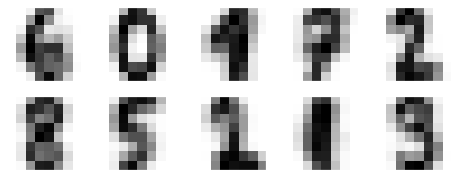

In [12]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers_img = centers.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers_img):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

## Точность кластеризации с помощью accuracy

In [13]:
from scipy.stats import mode

labels_dig = np.zeros_like(labels)
for i in range(10):
    mask = (labels == i)
    labels_dig[mask] = mode(digits.target[mask])[0]
    
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels_dig)

0.7061769616026711

## Adjusted Rand index

In [14]:
adjusted_rand_score(digits.target, labels_dig)

0.5886252361280013

## Silhouette Coefficient

In [15]:
np.mean(silhouette_samples(digits.data, labels))

0.16753289737816274

In [41]:
# %run cluster_kmeans.ipynb
%run cluster_kmeans_v2.ipynb

Converged at iteration 11
[2 4 3 3 1 1 0 1 1 3]
[2 4 3 3 1 1 0 1 1 3]


In [38]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000, centers=5, random_state=0)

km = KernelKMeans(n_clusters=5, max_iter=100, random_state=0, verbose=1)
print(km.fit_predict(X)[:10])
print(km.predict(X[:10]))

Converged at iteration 11
[2 4 3 3 1 1 0 1 1 3]
[2 4 3 3 1 1 0 1 1 3]


In [40]:
k_plusplus_means_find_clusters(X, n_clusters=5, iter_num=100)

(array([[ 9.24576378, -2.34401749],
        [-1.31500217,  7.89129694],
        [ 1.99653852,  0.75932427],
        [-1.41350987,  2.88804152],
        [ 0.94062017,  4.3305516 ]]),
 array([1, 3, 2, 2, 4, 4, 0, 4, 4, 2, 0, 1, 2, 3, 4, 4, 0, 2, 4, 3, 0, 0,
        3, 2, 3, 1, 3, 1, 0, 0, 4, 0, 0, 2, 0, 0, 2, 1, 0, 0, 2, 3, 1, 2,
        4, 3, 4, 3, 4, 1, 2, 4, 1, 4, 4, 0, 4, 0, 2, 2, 4, 0, 0, 4, 4, 1,
        1, 2, 3, 0, 3, 4, 0, 3, 2, 0, 0, 2, 2, 2, 1, 3, 0, 3, 2, 4, 1, 0,
        0, 4, 3, 3, 1, 3, 4, 4, 1, 3, 3, 3, 1, 3, 3, 0, 3, 4, 3, 0, 3, 4,
        4, 4, 3, 4, 2, 4, 0, 3, 0, 4, 4, 3, 1, 1, 3, 4, 2, 2, 1, 0, 2, 1,
        2, 0, 1, 4, 2, 4, 4, 4, 2, 0, 0, 0, 3, 2, 3, 4, 1, 1, 2, 4, 2, 0,
        2, 4, 2, 4, 2, 0, 1, 4, 3, 1, 2, 2, 4, 4, 4, 4, 3, 1, 0, 4, 2, 0,
        3, 3, 2, 0, 0, 2, 1, 1, 3, 1, 4, 2, 4, 1, 1, 1, 3, 4, 1, 0, 4, 0,
        3, 1, 3, 0, 0, 2, 0, 3, 1, 0, 4, 1, 1, 2, 0, 1, 4, 1, 4, 0, 1, 4,
        3, 3, 2, 2, 0, 2, 0, 2, 4, 2, 1, 0, 4, 4, 1, 2, 0, 0, 4, 2, 4, 4,
    